## Links de consultas e instalações de libs

In [ ]:
# https://dataplatform.cloud.ibm.com/exchange/public/entry/view/133dfc4cd1480bbe4eaa78d3f635e568
# https://cloud.ibm.com/docs/assistant?topic=assistant-logs-resources&locale=en

In [ ]:
!pip install --upgrade ibm-watson
!pip install --upgrade XlsxWriter
!pip install --upgrade bokeh
!pip install --upgrade assistant-improve-toolkit

     |████████████████████████████████| 389kB 15.6MB/s 
     |████████████████████████████████| 204kB 41.1MB/s 
  Created wheel for ibm-watson: filename=ibm_watson-5.1.0-cp37-none-any.whl size=375439 sha256=c5d09fafaa96cc584bb42060f2863c37074848082634244a1869c49170556dab
  Stored in directory: /root/.cache/pip/wheels/49/6d/cf/1d91261b96363da78bf9b02699fd2262e6b5dad179500690c1
  Created wheel for ibm-cloud-sdk-core: filename=ibm_cloud_sdk_core-3.9.0-cp37-none-any.whl size=59612 sha256=d8d2b8858fde9f609f8c3b9657c40f951e64443565b52ce7ebea93e2bd66fc03
  Stored in directory: /root/.cache/pip/wheels/a2/23/f2/ae9db79b4234ed0fc74bf00bc97bcd16440ab2764c5f443167
Successfully built ibm-watson ibm-cloud-sdk-core
     |████████████████████████████████| 153kB 22.6MB/s 
Requirement already up-to-date: bokeh in /usr/local/lib/python3.7/dist-packages (2.3.1)
     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 10.0MB 10.9MB/s 
     |█████████████████████████████

## Imports e recuperação de Log

In [ ]:
# Import required libraries
from datetime import datetime, date 

import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

from ibm_watson import AssistantV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from assistant_improve_toolkit.computation_func import format_data

%matplotlib inline

In [ ]:
# Recuperar os logs
authenticator = IAMAuthenticator('b13KLWlJ0SAqGvN103mpDWCSa0C8OHqL-KbkEySqaucb')
assistant = AssistantV1(
    version='2020-04-05',
    authenticator = authenticator
)

assistant.set_service_url('https://api.us-south.assistant.watson.cloud.ibm.com/instances/adf7390c-2637-49ae-b110-96afcc494e9a')

response=assistant.list_all_logs(
    filter='language::pt-br,workspace_id::7657d667-c080-48fc-a342-a39e839fa87a'
).get_result()

In [ ]:
# criar um dataframe com os dados brutos dos logs
df_logs = pd.DataFrame(response['logs'])

In [ ]:
response = assistant.list_intents(workspace_id='7657d667-c080-48fc-a342-a39e839fa87a').get_result()

intents = [item['intent'] for item in response['intents']]

df_intents = pd.DataFrame(intents, columns=['intent'])
df_intents.head()

,intent
0,boas_vindas
1,casos_graves
2,colapso
3,contato_infectado
4,distanciamento


In [ ]:
# dataframe com os dados de logs formatados
df_formatted = format_data(df_logs)

Extracting request and response ...
Extracting context and output ...
Extracting intents ...
Completed!


In [ ]:
# Descomentar essa linha e usar caso queira ver logs dos dias 9, 13 e 14/04
#df_formatted = pd.read_csv('logs_viridiana.csv', index_col=0)

In [ ]:
df_formatted.head()

,log_id,response.timestamp,response.context.conversation_id,request_input,response_text,response_entities,response.output.nodes_visited_s,response_dialog_request_counter,response_dialog_stack,response_dialog_turn_counter,response.top_intent_intent,response.top_intent_confidence,Date,Customer ID (must retain for delete)
0,3467403d-1021-41b1-80df-289154b5a7c3,2021-04-09 01:34:50.889000+00:00,d625fe65-dd69-4928-9b5a-08f027b745b1,prevencao,[],[],['node_3_1616363968497'],1,[{'dialog_node': 'node_3_1616363968497'}],1,prevencao,0.942662,2021-04-09,NaN
1,6a605ca2-919f-45ec-aae1-3c50082b126b,2021-04-09 01:30:52.183000+00:00,5a73c879-56c3-462b-afd7-004540f00c05,prevencao,[],[],['node_3_1616363968497'],1,[{'dialog_node': 'node_3_1616363968497'}],1,prevencao,0.942662,2021-04-09,NaN
2,91734306-8b2e-47ae-91b0-648bd174c0a9,2021-04-09 01:25:46.802000+00:00,94e8431c-2a21-481f-8658-318026f3f6bf,NaN,['Olá. Como posso te ajudar?'],[],['Bem-vindo'],1,[{'dialog_node': 'root'}],1,NaN,NaN,2021-04-09,NaN
3,054bf864-bef9-4575-b8a4-52049efc5e23,2021-04-09 01:26:33.065000+00:00,5eec8e8d-b0ac-4adf-a7cf-4be1037d0892,ola,['E ai'],[],['node_2_1616547303432'],1,[{'dialog_node': 'root'}],1,boas_vindas,1.000000,2021-04-09,NaN
4,f37390b3-1d3d-496d-9b28-9e1b8bcc6fd4,2021-04-09 02:02:47.253000+00:00,4861249e-22b3-4820-b5c3-223ff4bd654b,ola,['Como vai'],[],['node_2_1616547303432'],1,[{'dialog_node': 'root'}],1,boas_vindas,1.000000,2021-04-09,NaN


## Intents mais identificadas e Intends não usadas (ainda)


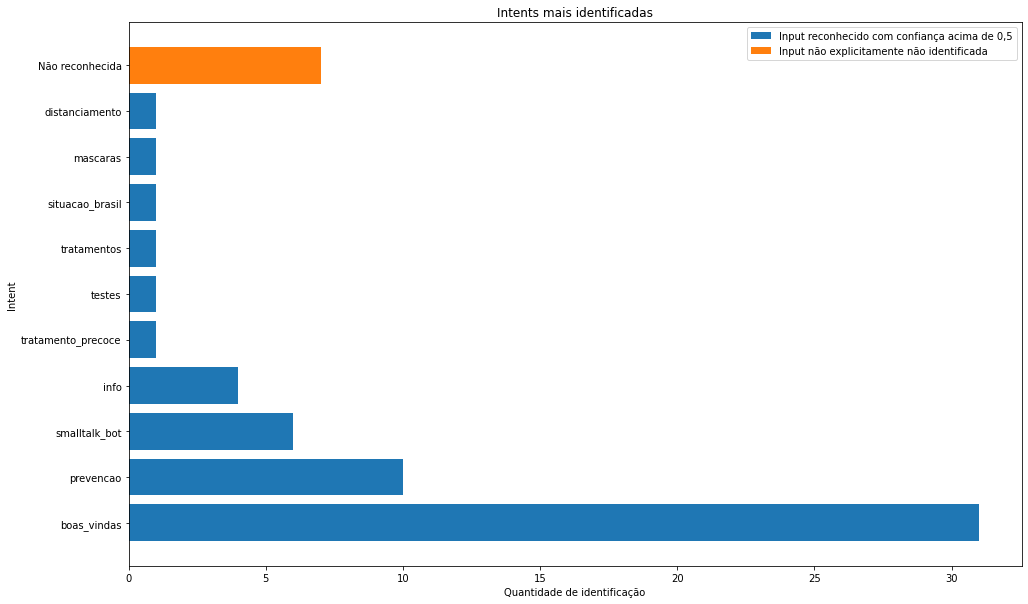

In [ ]:
df_formatted_no_nan = df_formatted[df_formatted['response.top_intent_intent'].notna()]

# confiança baixa provavelmente deve ter algum problema
counts_top_intents = df_formatted_no_nan[df_formatted_no_nan['response.top_intent_confidence'] > 0.5 ]['response.top_intent_intent'].value_counts()

# Contar os nan nas intens mais identificadas, pois eles indicariam mensagens não reconhecidas
# remover os com request_input input vazio pois é o bot comprimentando o usuário
counts_nan_intents = df_formatted[df_formatted['response.top_intent_intent'].isna() & df_formatted['request_input'].notna()].shape[0]

(fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))


ax.barh(counts_top_intents.index, counts_top_intents, label='Input reconhecido com confiança acima de 0,5')
if counts_nan_intents > 0:
  ax.barh('Não reconhecida', counts_nan_intents, label='Input não explicitamente não identificada')
ax.set_xlabel('Quantidade de identificação')
ax.set_ylabel('Intent')
ax.set_title('Intents mais identificadas')
ax.legend()

plt.show()

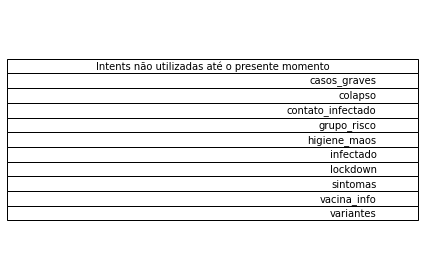

In [ ]:
 intent_nao_utilizadas = df_intents[~df_intents['intent'].isin(df_formatted['response.top_intent_intent'])].values

fig, ax = plt.subplots()

# esconder eixos
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=intent_nao_utilizadas,
        colLabels=['Intents não utilizadas até o presente momento'],
         loc='center')

fig.tight_layout()

plt.show()

In [ ]:
df_low_confidence = df_formatted_no_nan[df_formatted_no_nan['response.top_intent_confidence'] < 0.5 ]

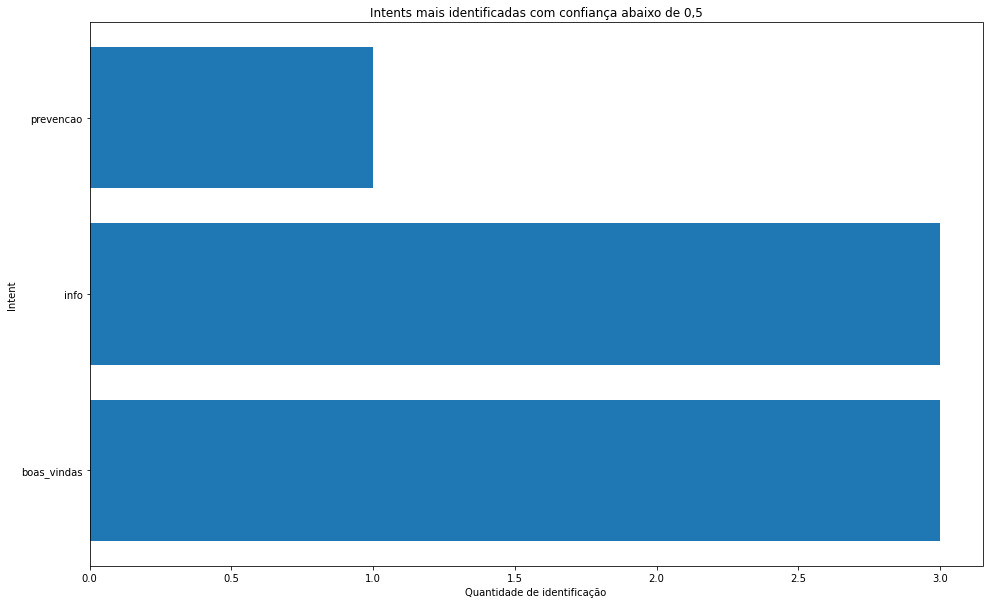

In [ ]:
counts_top_intents_low_confidence = df_low_confidence['response.top_intent_intent'].value_counts()

(fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))


ax.barh(counts_top_intents_low_confidence.index, counts_top_intents_low_confidence)
ax.set_xlabel('Quantidade de identificação')
ax.set_ylabel('Intent')
ax.set_title('Intents mais identificadas com confiança abaixo de 0,5')

plt.show()

## Quantidade de conversas e mensagens por Intent

In [ ]:
df_intents_por_conversa = df_formatted.groupby(['response.top_intent_intent']).agg({'response.context.conversation_id': ['nunique', 'count']}).reset_index(col_level=1)
df_intents_por_conversa.columns = df_intents_por_conversa.columns.get_level_values(1)
df_intents_por_conversa = df_intents_por_conversa.rename(columns={'nunique':'count_conversas', 'count':'count_mensagens'})

In [ ]:
df_intents_por_conversa

,response.top_intent_intent,count_conversas,count_mensagens
0,boas_vindas,28,34
1,distanciamento,1,1
2,info,2,7
3,mascaras,1,1
4,prevencao,7,11
5,situacao_brasil,1,1
6,smalltalk_bot,1,6
7,testes,1,1
8,tratamento_precoce,1,1
9,tratamentos,1,1


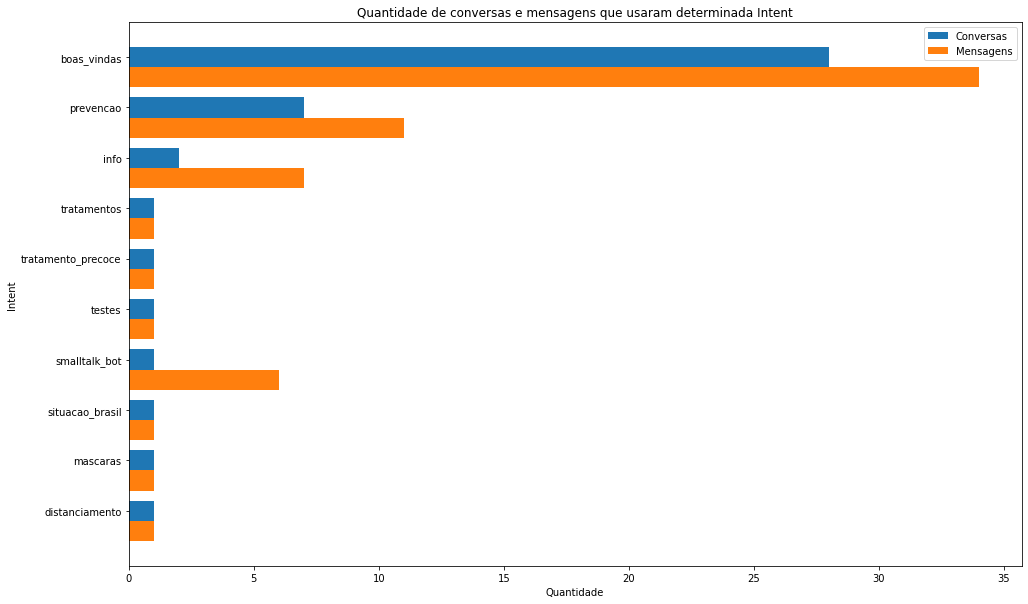

In [ ]:
df_intents_por_conversa = df_intents_por_conversa.sort_values(by=['count_conversas'])

indices = np.arange(len(df_intents_por_conversa['response.top_intent_intent']))
width = 0.4

(fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

ax.barh(indices + width, 
        df_intents_por_conversa['count_conversas'],
        width,
        label='Conversas')
ax.barh(indices, 
        df_intents_por_conversa['count_mensagens'],
        width,
        label='Mensagens')

ax.set_xlabel('Quantidade')
ax.set_ylabel('Intent')
ax.set_yticks(indices + width)
ax.set_yticklabels(df_intents_por_conversa['response.top_intent_intent'])
ax.set_title('Quantidade de conversas e mensagens que usaram determinada Intent')
ax.legend()

plt.show()

## Volumetria

Avaliar o número de mensagens e conversas por dia presentes no Log

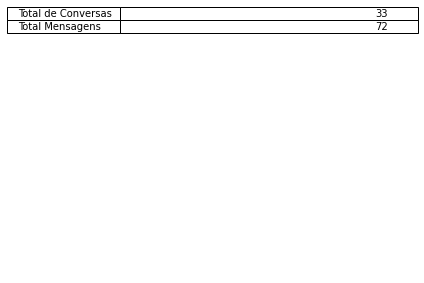

In [ ]:
# Computar o número de conversações no Log 
convs = df_formatted['response.context.conversation_id'].nunique()

# Computar o número de mensagens nos logs
msgs = df_formatted['response.context.conversation_id'].size

#print('Total de Conversas: ', convs, '\nTotal Mensagens: ', msgs, '\n\n', sep = '')

fig, ax = plt.subplots()

# esconder eixos
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=[[convs], [msgs]],
         rowLabels=['Total de Conversas', 'Total Mensagens'],
         loc='top')

fig.tight_layout()

plt.show()

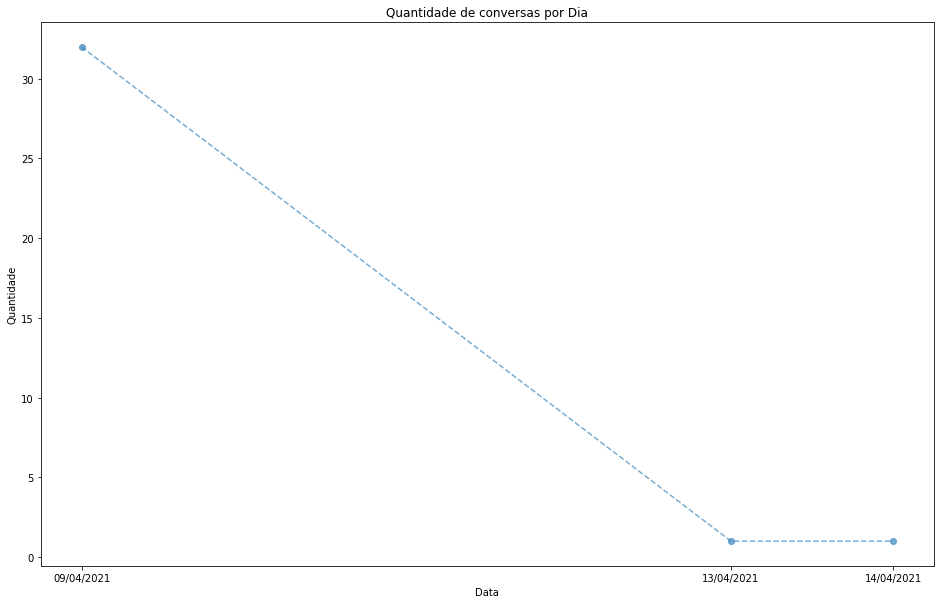

In [ ]:
count_conversacoes_group_date = df_formatted.groupby(df_formatted['Date'])['response.context.conversation_id'].nunique()

(fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

ax.plot(count_conversacoes_group_date.index, count_conversacoes_group_date, 'o--', alpha=0.6)
if len(count_conversacoes_group_date) < 10:
  ax.set_xticks(count_conversacoes_group_date.index) # como tem poucas entradas, dá pra fazer isso
ax.set_ylabel('Quantidade')
ax.set_xlabel('Data')
ax.set_title('Quantidade de conversas por Dia')

myFmt = mdates.DateFormatter('%d/%m/%Y')
ax.xaxis.set_major_formatter(myFmt)

#ax.legend()

plt.show()

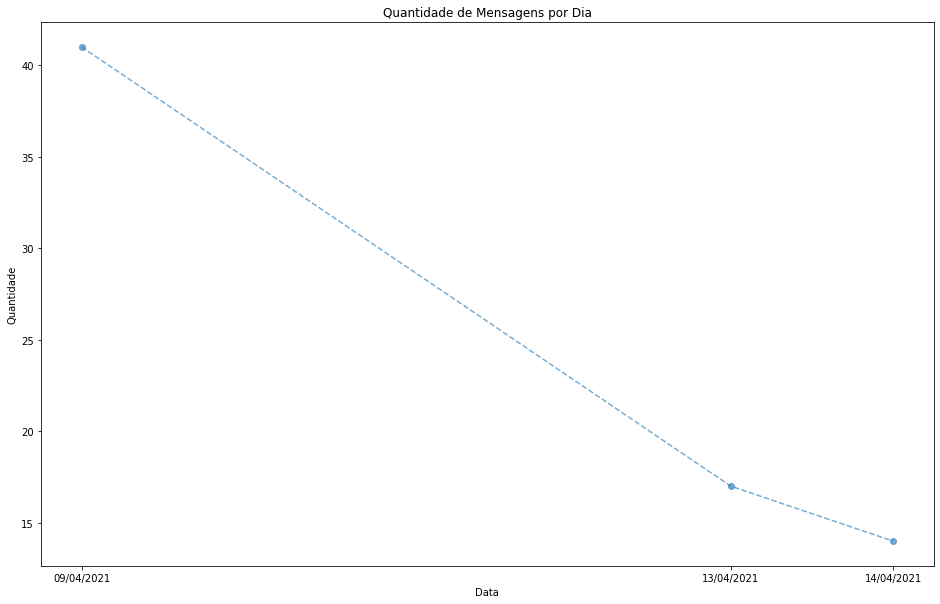

In [ ]:
count_mensagens_group_date = df_formatted.groupby(df_formatted['Date'])['response.context.conversation_id'].size()

(fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

ax.plot(count_mensagens_group_date.index, count_mensagens_group_date, 'o--', alpha=0.6)
if len(count_mensagens_group_date) < 10:
  ax.set_xticks(count_mensagens_group_date.index) # como tem poucas entradas, dá pra fazer isso
ax.set_ylabel('Quantidade')
ax.set_xlabel('Data')
ax.set_title('Quantidade de Mensagens por Dia')

myFmt = mdates.DateFormatter('%d/%m/%Y')
ax.xaxis.set_major_formatter(myFmt)

#ax.legend()

plt.show()

## Medidas de tendência central

In [ ]:
df_mesagens_per_conversation = df_formatted[df_formatted['request_input'].notna()].groupby('response.context.conversation_id').agg({'response.top_intent_intent': 'count'}).reset_index().rename(columns={'response.top_intent_intent':'count_mensagens'})

In [ ]:
media = df_mesagens_per_conversation['count_mensagens'].mean()
mediana = df_mesagens_per_conversation['count_mensagens'].median()
print('Média de mensagens por conversa: ', media, '\nMédiana de mensagens por conversa: ', mediana, '\n\n', sep = '')

Média de mensagens por conversa: 2.0
Médiana de mensagens por conversa: 1.0




## Conversas

In [ ]:
df_sorted = df_mesagens_per_conversation.sort_values('count_mensagens',ascending = False)
count_five_longest = df_sorted.head(5)
count_five_shortest = df_sorted.tail(5)

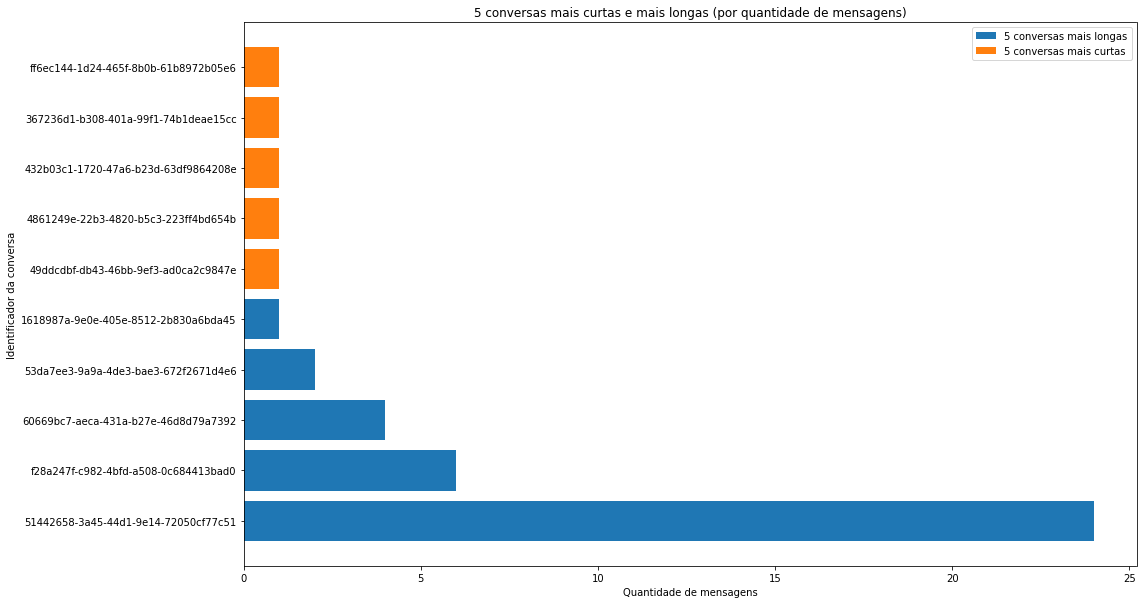

In [ ]:
(fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

ax.barh(count_five_longest['response.context.conversation_id'], count_five_longest['count_mensagens'], label='5 conversas mais longas')
ax.barh(count_five_shortest['response.context.conversation_id'], count_five_shortest['count_mensagens'], label='5 conversas mais curtas')
ax.set_xlabel('Quantidade de mensagens')
ax.set_ylabel('Identificador da conversa')
ax.set_title('5 conversas mais curtas e mais longas (por quantidade de mensagens)')
ax.legend()

plt.show()

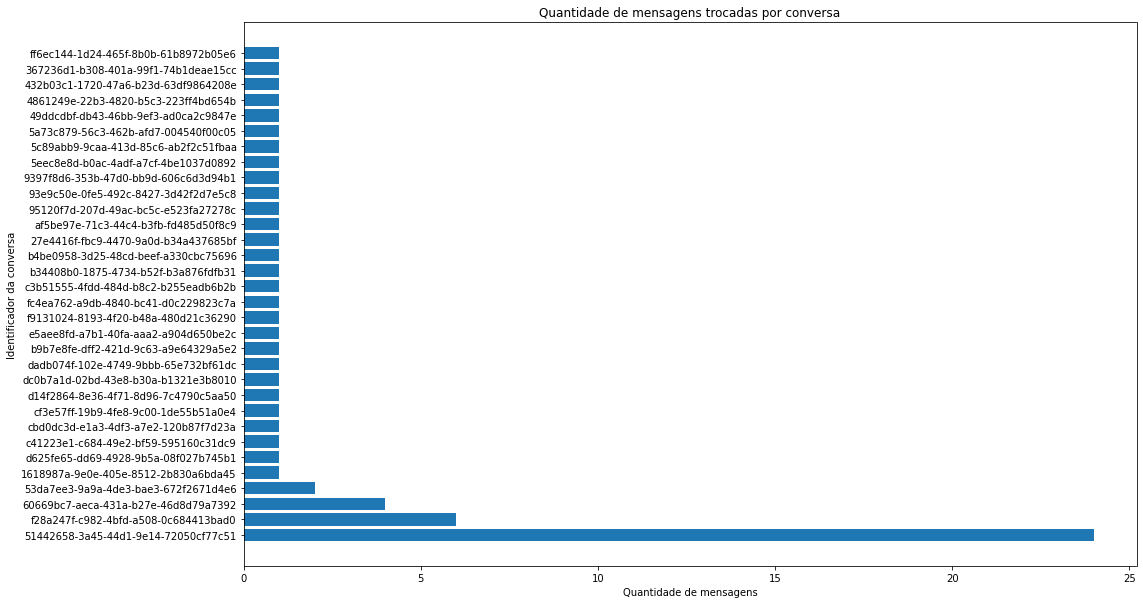

In [ ]:
# Essa célula pode ser ignorada é mais uma forma de exibição geral de todos as conversas, poderia muito bem ser uma tabela
(fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

ax.barh(df_sorted['response.context.conversation_id'], df_sorted['count_mensagens'])
ax.set_xlabel('Quantidade de mensagens')
ax.set_ylabel('Identificador da conversa')
ax.set_title('Quantidade de mensagens trocadas por conversa')
#ax.legend()

plt.show()

In [ ]:
df_low_confidence_counts = df_low_confidence.groupby('response.context.conversation_id').agg({'response.top_intent_intent': 'count'}).reset_index().rename(columns={'response.top_intent_intent':'count_mensagens'})

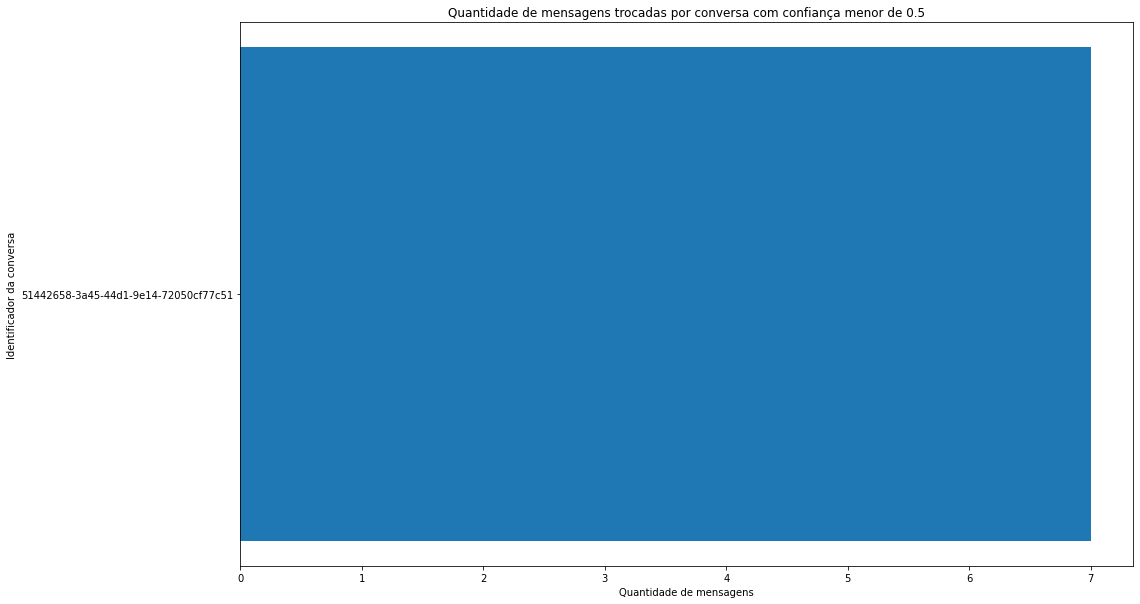

In [ ]:
df_sorted_low_confidend = df_low_confidence_counts.sort_values('count_mensagens',ascending = False)
(fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

ax.barh(df_sorted_low_confidend['response.context.conversation_id'], df_sorted_low_confidend['count_mensagens'])
ax.set_xlabel('Quantidade de mensagens')
ax.set_ylabel('Identificador da conversa')
ax.set_title('Quantidade de mensagens trocadas por conversa com confiança menor de 0.5')

plt.show()

# Gráficos com os NaNs

In [ ]:
#remover os com request_input input vazio pois é o bot comprimentando o usuário
df_nan = df_formatted[df_formatted['response.top_intent_intent'].isna() & df_formatted['request_input'].notna()]
df_nan.head()

,log_id,response.timestamp,response.context.conversation_id,request_input,response_text,response_entities,response.output.nodes_visited_s,response_dialog_request_counter,response_dialog_stack,response_dialog_turn_counter,response.top_intent_intent,response.top_intent_confidence,Date,Customer ID (must retain for delete)
49,b860b916-fb06-49b1-b455-e139820ec748,2021-04-13 23:59:40.020000+00:00,51442658-3a45-44d1-9e14-72050cf77c51,não que saber disso,[Eu não entendi o sentido.],"[{'entity': 'nao', 'location': [0, 3], 'value'...",[Em outros casos],16,[{'dialog_node': 'root'}],16,NaN,NaN,2021-04-13,
54,18462838-71bc-417c-84d1-62bc1a644911,2021-04-13 23:59:08.378000+00:00,51442658-3a45-44d1-9e14-72050cf77c51,acho que não,[Você pode reformular sua afirmação? Eu não es...,"[{'entity': 'nao', 'location': [9, 12], 'value...",[Em outros casos],12,[{'dialog_node': 'root'}],12,NaN,NaN,2021-04-13,
56,1a69f299-c242-42c9-b830-84dc6bfb909c,2021-04-13 23:56:51.669000+00:00,51442658-3a45-44d1-9e14-72050cf77c51,Não me referia ao fato dos testes mas sim sobr...,[Eu não entendi. Você pode tentar reformular a...,"[{'entity': 'nao', 'location': [0, 3], 'value'...",[Em outros casos],3,[{'dialog_node': 'root'}],3,NaN,NaN,2021-04-13,
60,e8cbb687-fb70-4c90-b8ff-f01f0e46c427,2021-04-14 00:02:48.338000+00:00,51442658-3a45-44d1-9e14-72050cf77c51,ein?,[Eu não entendi. Você pode tentar reformular a...,[],[Em outros casos],20,[{'dialog_node': 'root'}],20,NaN,NaN,2021-04-14,
64,4fac4ed4-041d-41e6-bf97-5e46b6c593db,2021-04-14 00:06:54.353000+00:00,51442658-3a45-44d1-9e14-72050cf77c51,lg,[Você pode reformular sua afirmação? Eu não es...,[],[Em outros casos],24,[{'dialog_node': 'root'}],24,NaN,NaN,2021-04-14,


In [ ]:
# agregar em uma forma mais fácil de plotar
df_nan = df_nan.groupby('response.context.conversation_id').agg({'response.top_intent_intent': 'size'}).reset_index().rename(columns={'response.top_intent_intent':'count_mensagens'})
df_nan.head()

,response.context.conversation_id,count_mensagens
0,51442658-3a45-44d1-9e14-72050cf77c51,7


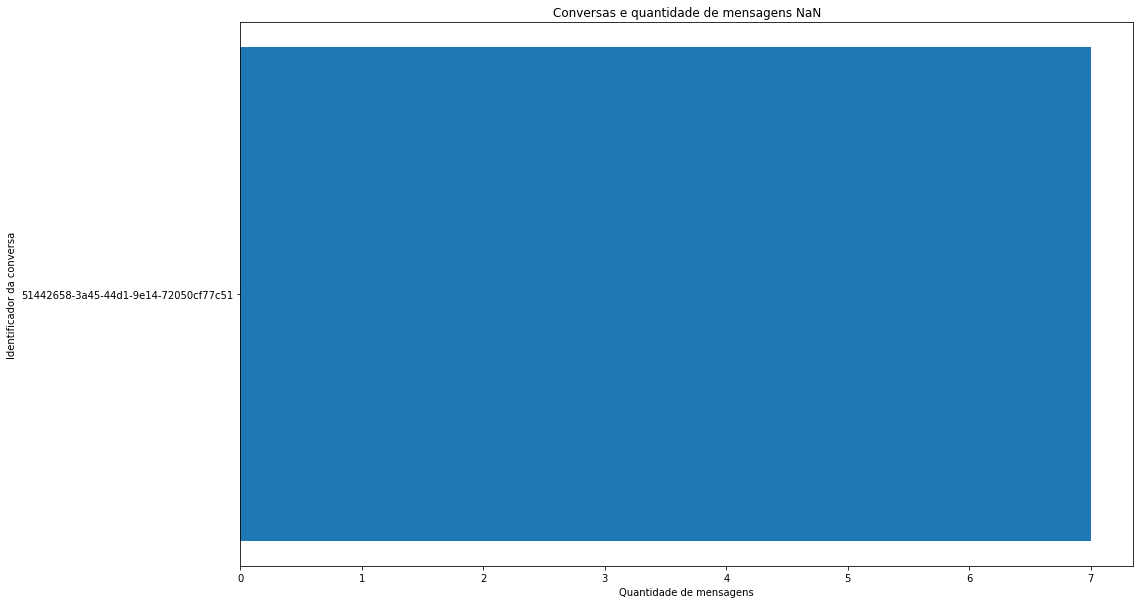

In [ ]:
(fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

ax.barh(df_nan['response.context.conversation_id'], df_nan['count_mensagens'])
ax.set_xlabel('Quantidade de mensagens')
ax.set_ylabel('Identificador da conversa')
ax.set_title('Conversas e quantidade de mensagens NaN')

plt.show()